# Tasks for lectures 9-10
Build a convolutional neural network(CNN) for font recognition based on the given datasets(excluded three large files with size > 100 MB as of limitations of github storage).

Step 0: import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import requests
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

Step 1: fetch fonts csv urls from github api

In [ ]:
api_url = 'https://api.github.com/repos/DatenFluss/machine-learning-university-course/contents/res/fonts'
response = requests.get(api_url)
contents = response.json()

Step 2: extract url's of the csv files

In [ ]:
csv_urls = []
for item in contents:
    if item['name'].endswith('.csv'):
        raw_url = item['download_url']
        csv_urls.append(raw_url)

Step 3: load and combine the csv files

In [ ]:
dataframes = []
for url in csv_urls:
    df = pd.read_csv(url)
    dataframes.append(df)

data = pd.concat(dataframes, ignore_index=True)

Step 4: verify the data

In [ ]:
print(data.head())
print('Combined data shape:', data.shape)

     font fontVariant  m_label  strength  italic  orientation  m_top  m_left  \
0  AGENCY   AGENCY FB    64258       0.4       0          0.0     35      21   
1  AGENCY   AGENCY FB    64257       0.4       0          0.0     35      21   
2  AGENCY   AGENCY FB    61442       0.4       0          0.0     35      21   
3  AGENCY   AGENCY FB    61441       0.4       0          0.0     35      21   
4  AGENCY   AGENCY FB     9674       0.4       0          0.0     51      21   

   originalH  originalW  ...  r19c10  r19c11  r19c12  r19c13  r19c14  r19c15  \
0         51         22  ...       1       1       1       1       1       1   
1         51         22  ...       1       1       1       1       1       1   
2         51         22  ...       1       1       1       1       1       1   
3         51         22  ...       1       1       1       1       1       1   
4         33         25  ...     255     132       1       1       1       1   

   r19c16  r19c17  r19c18  r19c19  
0 

Step 5: preprocess the data

In [ ]:
pixel_columns = ['r{}c{}'.format(r, c) for r in range(20) for c in range(20)]
X = data[pixel_columns].values
y = data['font'].values

Step 6: encode the labels

In [ ]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(np.unique(y_encoded))
y_categorical = to_categorical(y_encoded, num_classes)

Step 7: normalize pixel data

In [ ]:
X = X / 255.0

# Reshape data for CNN input
X = X.reshape(-1, 20, 20, 1)

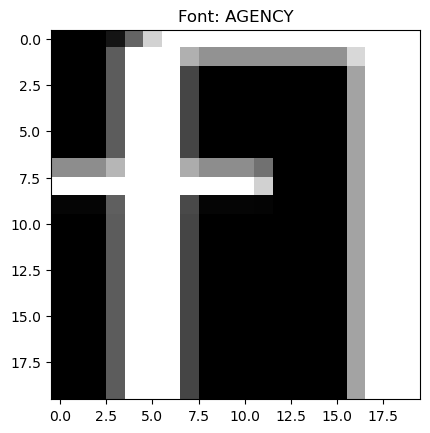

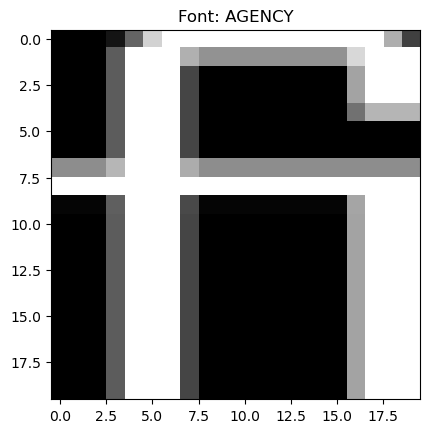

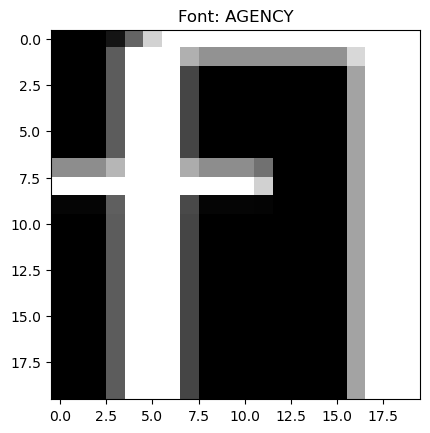

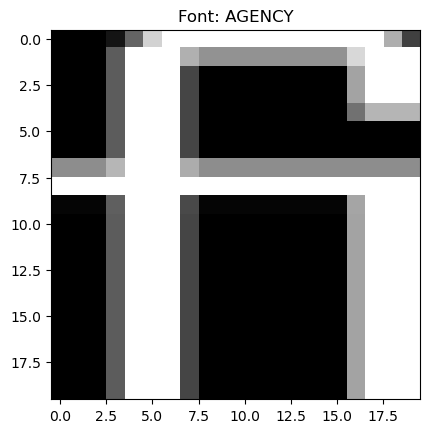

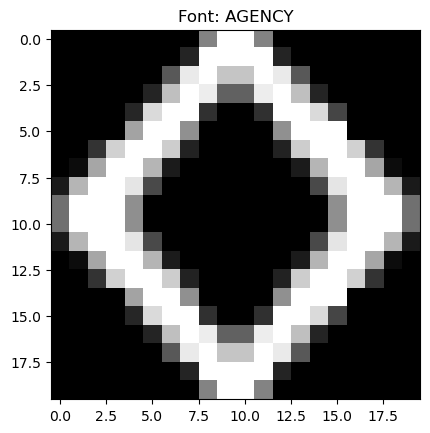

In [ ]:
for i in range(5):
    plt.imshow(X[i].reshape(20, 20), cmap='gray')
    plt.title(f'Font: {y[i]}')
    plt.show()

Step 8: Split the data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_encoded
)

datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=10,
    zoom_range=0.1,
    shear_range=0.1
)
datagen.fit(X_train)

Step 9: Build the model for a feedforward neural network.

Additional possible improvements:
Dropout Layers: Prevent overfitting by randomly dropping neurons during training.
L2 Regularization: Penalize large weights to encourage simpler models.

In [ ]:
model = Sequential()

# First convolutional block
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(20, 20, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding='same'))

# Second convolutional block
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding='same'))

# Third convolutional block
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())

# Global average pooling
model.add(GlobalAveragePooling2D())

# Fully connected layer
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_classes, activation='softmax'))

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Step 9: Compile the model

In [ ]:
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Step 10: Train model with data augmentation

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True
)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6554/6554 ━━━━━━━━━━━━━━━━━━━━ 185s 28ms/step - accuracy: 0.2020 - loss: 3.6712 - val_accuracy: 0.3046 - val_loss: 2.8933
Epoch 2/100
6554/6554 ━━━━━━━━━━━━━━━━━━━━ 178s 27ms/step - accuracy: 0.3114 - loss: 2.8665 - val_accuracy: 0.3674 - val_loss: 2.5077
Epoch 3/100
6554/6554 ━━━━━━━━━━━━━━━━━━━━ 170s 26ms/step - accuracy: 0.3442 - loss: 2.6739 - val_accuracy: 0.4047 - val_loss: 2.3532
Epoch 4/100
6554/6554 ━━━━━━━━━━━━━━━━━━━━ 179s 27ms/step - accuracy: 0.3639 - loss: 2.5589 - val_accuracy: 0.4265 - val_loss: 2.2405
Epoch 5/100
6554/6554 ━━━━━━━━━━━━━━━━━━━━ 174s 27ms/step - accuracy: 0.3812 - loss: 2.4827 - val_accuracy: 0.4332 - val_loss: 2.2057
Epoch 6/100
6554/6554 ━━━━━━━━━━━━━━━━━━━━ 178s 27ms/step - accuracy: 0.3917 - loss: 2.4190 - val_accuracy: 0.4352 - val_loss: 2.2024
Epoch 7/100
6554/6554 ━━━━━━━━━━━━━━━━━━━━ 171s 26ms/step - accuracy: 0.3997 - loss: 2.3750 - val_accuracy: 0.4487 - val_loss: 2.1330
Epoch 8/100
6554/6554 ━━━━━━━━━━━━━━━━━━━━ 175s 27ms/step - accuracy: 0.40

Step 11: Evaluate the model

In [ ]:
model.load_weights('best_model.keras')
loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)

3277/3277 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5558 - loss: 1.7024
Test accuracy: 0.554940938949585


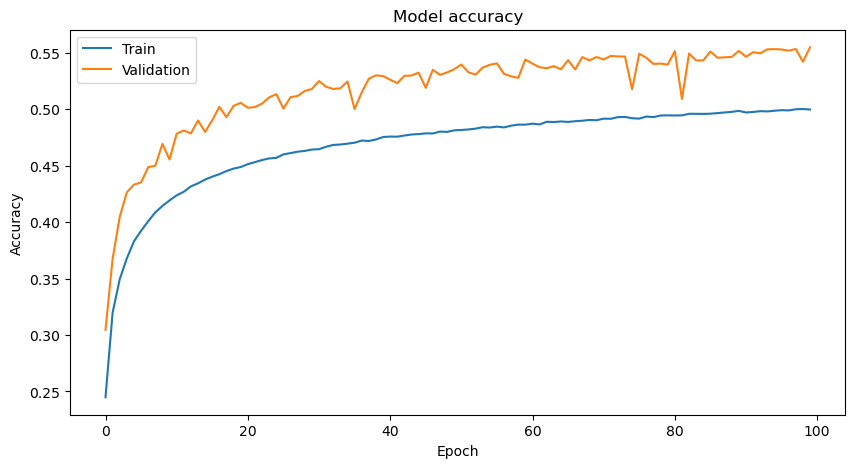

In [ ]:
# Accuracy plot
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

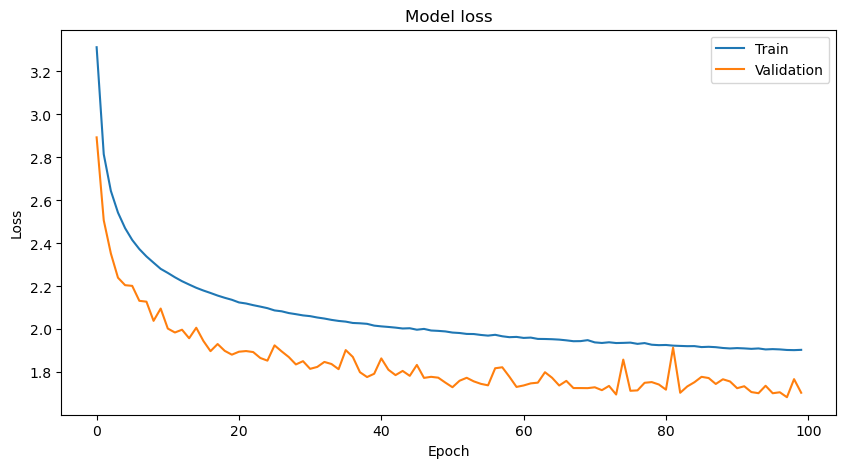

In [ ]:
# Loss plot
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Step 8: Save the trained model
model.save('font_recognition_cnn.keras')